In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.nn.utils import parameters_to_vector, vector_to_parameters
from torch.autograd import Variable
from sklearn.decomposition import PCA
import pandas as pd
import copy
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
import matplotlib
from matplotlib.pyplot import figure

In [37]:
torch.manual_seed(1)

In [38]:
# MNIST dataset 
train_dataset = torchvision.datasets.MNIST(root='./data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),  
                                           download=False)

test_dataset = torchvision.datasets.MNIST(root='./data', 
                                          train=False, 
                                          transform=transforms.ToTensor())

print("train_dataset size:", len(train_dataset),"\ntest_dataset size:", len(test_dataset))

train_dataset size: 60000 
test_dataset size: 10000


In [39]:
# Data loader func
def train_loader(batch_size):
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size = batch_size, 
                                           shuffle=True)
    return train_loader


def test_loader(batch_size):
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)
    return test_loader

In [40]:
class DNN(nn.Module):
    def __init__(self,):
        super(DNN, self).__init__()
        self.fc1 = nn.Linear(784, 500)
        self.fc2 = nn.Linear(500, 50)
        self.fc3 = nn.Linear(50, 10)

    def forward(self, x):
        # flatten as one dimension
        x = x.reshape(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [41]:
# m = DNN()
# p1=torch.nn.utils.parameters_to_vector(m.fc1.weight.data).detach().numpy()

# print(p1)

In [42]:
# testDict = {}

# for name, parameter in m.named_parameters():
#     if'weight' in name:
#         testDict['b'] = (torch.nn.utils.parameters_to_vector(parameter).detach().numpy())
#         #testDict['b'].append(weights2)
# len(testDict)

In [43]:
# temp_df = pd.DataFrame()
# for name, parameter in m.named_parameters():
#             if 'weight' in name:
#                 weights = torch.nn.utils.parameters_to_vector(parameter).detach().numpy() 
#                 temp_df = pd.concat([temp_df, pd.DataFrame(weights).T], axis = 1)
                
# temp_df

In [44]:
# temp_df = pd.DataFrame()
# for name, parameter in m.named_parameters():
#             if 'weight' in name and 'fc3'in name:
#                 weights = torch.nn.utils.parameters_to_vector(parameter).detach().numpy() 
#                 temp_df = pd.concat([temp_df, pd.DataFrame(weights).T], axis = 1)
                
# temp_df

In [45]:
# print(p1 == p2)

In [59]:
#train function
def trainFunc(model,num_epochs,train_batch_size,status_interval):
    model.train()
    print('strated')
    train_load = train_loader(train_batch_size)
    n_total_steps = len(train_load)
    train_losses = []
    train_epoch = []
    train_acc = []
    epoch = 0
    modelParamWgt = pd.DataFrame()
    trainAvgLossArr = []
    trainAvgAccArr = []
    firstParaWgt = {}

    for epoch in range (num_epochs):
        epoch += 1
        n_correct = 0
        n_samples = 0
        lossSum =0
        totalacc=0
        epoch_df = pd.DataFrame()

        for i, (images, labels) in enumerate(train_load):  
            #if (i+1)% 60 == 0 : print(i+1)
            images, labels = Variable(images),Variable(labels)
            
            optimizer.zero_grad()
            
            # Forward pass
            prediction = model(images)

            images.requires_grad = True

            loss = loss_func(prediction, labels)
            lossSum += loss.detach().numpy()

            # Backward and optimize
            
            loss.backward()

            optimizer.step()

            _, predicted = torch.max(prediction.data, 1)
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()
            acc = 100.0 * n_correct / n_samples
            totalacc += acc

            train_losses.append(loss.item())
            train_acc.append(acc)
            train_epoch.append(epoch)

            #Print Status
            if (i+1) % status_interval == 0:
                print (f'Train O/P: Epoch [{epoch}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}',end= '\r',flush = True)
        
        #Weight Collection
        for name, parameter in model.named_parameters():
            #print(name)
            if'weight' in name:
                weights = torch.nn.utils.parameters_to_vector(parameter).detach().numpy() 
                epoch_df = pd.concat([epoch_df, pd.DataFrame(weights).T], axis = 1) 

        modelParamWgt = pd.concat([modelParamWgt, epoch_df], axis = 0)     

       
        epochLoss = lossSum/n_total_steps
        epochAcc = totalacc/n_total_steps
        #print("Train Avg loss:",trainAvgLoss)
        trainAvgLossArr.append(epochLoss)    
        trainAvgAccArr.append(epochAcc)
                       
    return train_epoch,train_losses,train_acc,trainAvgLossArr,trainAvgAccArr, modelParamWgt, firstParamWgt

In [60]:
def testFunction(model,loss_func,test_batch_size): 
    test_load = test_loader(test_batch_size)
    model.eval()
    with torch.no_grad():
        n_correct = 0
        n_samples = 0
        testLoss = 0
        count = 0
        for images, labels in test_load:
            images, labels = Variable(images),Variable(labels)
            
            prediction = model(images)
            testLoss += loss_func(prediction,labels).item()
            # max returns (value ,index)
            _, predicted = torch.max(prediction.data, 1)
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()
            count += 1
    netTest_loss = testLoss/count
    netTest_acc1 = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the test images: {netTest_acc1}% & Test Loss: {netTest_loss}',end= '\r',flush = True)
    return netTest_acc1, netTest_loss

In [61]:
def pcaOps(paramDF,itr):
    pcaOperation =  PCA(n_components=2)

    pcaVal = pcaOperation.fit_transform(paramDF)

    itrData = np.full((pcaVal.shape[0],1),itr)

    pcaDf = pd.DataFrame(np.append(pcaVal,itrData,axis=1),columns=['x','y','Itr No.'])

    return pcaDf


In [62]:
a=[]
tempModel = DNN()
for i in tempModel.parameters():
    a.append(torch.numel(i))
print(f'Total no of parameters:{np.sum(a)}')

Total no of parameters:418060


In [64]:
#2nd Approach

max_epochs = 45
all_df = pd.DataFrame()
columns=["x","y","Times"]
trainAllacc={}
testAllacc={}
trainAllloss={}
testAllloss={}
train_batch_size = 1000
test_batch_size = 1000
status_interval = 60
loss_func = nn.CrossEntropyLoss()
firstLayer = pd.DataFrame()

for count in range(8):

    j = copy.deepcopy(count)

    j = DNN()  

    print("Time: "+str(count))
    optimizer = torch.optim.Adam(j.parameters(),lr = 0.0004,weight_decay=1e-4)
    model_name1 = "Times:"+str(count)  
    
    train_epoch,train_losses,train_acc,trainAvgLoss,trainAvgAccArr, modelParamWgt,firstParamWgt = trainFunc(j,max_epochs,train_batch_size,status_interval)
    testAcc, testLoss = testFunction(j,loss_func,test_batch_size)

    # all_df = all_df.append(modelParamWgt)
    all_df = pd.concat([all_df, modelParamWgt], ignore_index=True)

    
    testAllacc[count] = testAcc
    trainAllloss[count] = trainAvgLoss
    testAllloss[count] = testLoss
    trainAllacc[count] = trainAvgAccArr


Time: 0
strated
Time: 1y of the network on the test images: 98.07% & Test Loss: 0.06428556125611067
strated
Time: 2y of the network on the test images: 97.93% & Test Loss: 0.06369569431990385
strated
Time: 3y of the network on the test images: 98.01% & Test Loss: 0.0626316367648542
strated
Time: 4y of the network on the test images: 97.95% & Test Loss: 0.06304743364453316
strated
Time: 5y of the network on the test images: 98.1% & Test Loss: 0.06030322695150971
strated
Time: 6y of the network on the test images: 98.1% & Test Loss: 0.06192756332457065
strated
Time: 7y of the network on the test images: 98.12% & Test Loss: 0.060960115678608415
strated


In [65]:
trainAccArr = []
for key,values in enumerate(trainAllacc):
    trainAccArr.append(trainAllacc[key])
trainLossArr = []
for key,values in enumerate(trainAllloss):
    trainLossArr.append(trainAllloss[key])


In [66]:
all_df

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,-1.689024e-05,-6.965429e-03,3.712421e-04,1.919224e-04,-4.546364e-04,3.164315e-04,-8.214783e-05,9.297777e-03,-5.066690e-03,-9.594068e-03,...,0.023463,-0.030177,-0.152116,-0.090438,-0.081353,-0.043454,0.028478,-0.103203,-0.103156,0.029706
1,-4.872207e-06,-4.484112e-04,2.001950e-05,-9.860850e-06,3.621669e-05,1.652052e-05,3.899069e-06,1.160118e-03,-7.499820e-05,-1.268470e-03,...,0.015411,-0.025413,-0.161321,-0.097878,-0.071004,-0.055247,0.037138,-0.106970,-0.103180,0.039604
2,2.000710e-07,1.660877e-05,4.216743e-07,2.269071e-08,1.096167e-06,3.457460e-08,2.476396e-08,1.589671e-05,7.691043e-06,-2.559060e-05,...,0.008887,-0.020298,-0.165805,-0.105144,-0.071722,-0.061026,0.039980,-0.110685,-0.110047,0.044325
3,-8.013306e-09,-4.299897e-07,-3.587117e-08,1.788395e-08,2.137980e-08,-4.038991e-08,1.191822e-10,-1.931409e-06,-3.294503e-07,2.279557e-06,...,0.005753,-0.015493,-0.170304,-0.111019,-0.076570,-0.064595,0.041264,-0.112138,-0.120591,0.047499
4,-3.829073e-10,1.720252e-08,-2.266040e-11,8.486928e-10,1.187444e-09,1.180795e-09,2.656696e-10,8.392375e-08,7.976898e-09,-8.673918e-08,...,0.005876,-0.011343,-0.174125,-0.116158,-0.082193,-0.067511,0.041610,-0.113250,-0.130297,0.050444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,3.658720e-39,-1.383715e-38,6.847771e-39,3.935181e-38,-1.410310e-38,4.065584e-39,-1.409821e-38,1.462359e-38,9.829129e-39,-8.431027e-39,...,0.045161,0.215272,0.212163,-0.372753,0.054637,-0.132127,-0.003358,0.203284,0.019201,0.187725
356,3.658720e-39,-1.383715e-38,6.847771e-39,-6.951230e-38,-1.410310e-38,4.065584e-39,-1.409821e-38,1.462359e-38,9.829129e-39,-8.431027e-39,...,0.044941,0.216097,0.213752,-0.377097,0.054297,-0.133269,-0.003639,0.204846,0.019395,0.189448
357,3.658720e-39,-1.383715e-38,6.847771e-39,-7.003152e-38,-1.410310e-38,4.065584e-39,-1.409821e-38,1.462359e-38,9.829129e-39,-8.431027e-39,...,0.045135,0.217264,0.216223,-0.381109,0.054065,-0.134295,-0.003283,0.206915,0.019467,0.191398
358,3.658720e-39,-1.383715e-38,6.847771e-39,-7.052578e-38,-1.410310e-38,4.065584e-39,-1.409821e-38,1.462359e-38,9.829129e-39,-8.431027e-39,...,0.045311,0.218467,0.218365,-0.385007,0.053782,-0.135288,-0.002791,0.208819,0.019762,0.193468


In [67]:
train_acc_df = pd.DataFrame(trainAccArr)
train_acc_data = np.array(train_acc_df).flatten()

train_loss_df = pd.DataFrame(trainLossArr)
train_loss_data = np.array(train_loss_df).flatten()

print(f'Shape of Loss:{np.shape(train_loss_data)} & Shape of Acc: {np.shape(train_acc_data)}')


Shape of Loss:(360,) & Shape of Acc: (360,)


In [68]:
t1 = all_df
print(pd.DataFrame(t1))

              0             1             2             3             4    \
0   -1.689024e-05 -6.965429e-03  3.712421e-04  1.919224e-04 -4.546364e-04   
1   -4.872207e-06 -4.484112e-04  2.001950e-05 -9.860850e-06  3.621669e-05   
2    2.000710e-07  1.660877e-05  4.216743e-07  2.269071e-08  1.096167e-06   
3   -8.013306e-09 -4.299897e-07 -3.587117e-08  1.788395e-08  2.137980e-08   
4   -3.829073e-10  1.720252e-08 -2.266040e-11  8.486928e-10  1.187444e-09   
..            ...           ...           ...           ...           ...   
355  3.658720e-39 -1.383715e-38  6.847771e-39  3.935181e-38 -1.410310e-38   
356  3.658720e-39 -1.383715e-38  6.847771e-39 -6.951230e-38 -1.410310e-38   
357  3.658720e-39 -1.383715e-38  6.847771e-39 -7.003152e-38 -1.410310e-38   
358  3.658720e-39 -1.383715e-38  6.847771e-39 -7.052578e-38 -1.410310e-38   
359  3.658720e-39 -1.383715e-38  6.847771e-39 -7.099633e-38 -1.410310e-38   

              5             6             7             8             9    

In [69]:
t1 = np.array(t1)
pca = PCA(n_components=2)
new_data = pca.fit_transform(t1)
# scaling=StandardScaler()
# scaled_data = scaling.fit_transform(new_data)

allEpochDf = pd.DataFrame(new_data,columns=['x','y'])

eps_each_time = [i for i in range(max_epochs)] * 8
times = np.repeat([i for i in range(8)],max_epochs)

allEpochDf['Epoch']=eps_each_time
allEpochDf['Iteration']=(times)
allEpochDf["Acc"] = train_acc_data
allEpochDf["Loss"] = train_loss_data

allEpochDf


,x,y,Epoch,Iteration,Acc,Loss
0,5.800532,0.919293,0,0,50.873415,1.328536
1,7.124993,1.116661,1,0,88.582841,0.394028
2,7.962470,1.229773,2,0,91.481486,0.293641
3,8.671165,1.330115,3,0,92.658110,0.249844
4,9.266648,1.409732,4,0,93.688368,0.218776
...,...,...,...,...,...,...
355,-5.205361,-2.045316,40,7,99.666014,0.019553
356,-5.195198,-2.042097,41,7,99.649395,0.019079
357,-5.179784,-2.033664,42,7,99.727859,0.017760
358,-5.170141,-2.029937,43,7,99.732552,0.017138


In [70]:
epoch3Df = allEpochDf.loc[(allEpochDf['Epoch']+1)%3 == 0]
epoch3Df = epoch3Df.reset_index(drop=True)
epoch3Df

,x,y,Epoch,Iteration,Acc,Loss
0,7.962470,1.229773,2,0,91.481486,0.293641
1,9.791952,1.479439,5,0,94.404268,0.194637
2,11.022217,1.629305,8,0,95.867659,0.144954
3,11.863276,1.726766,11,0,96.998937,0.112926
4,12.456681,1.801961,14,0,97.471929,0.090320
...,...,...,...,...,...,...
115,-5.250891,-2.073007,32,7,99.335413,0.029404
116,-5.241033,-2.065203,35,7,99.535752,0.024723
117,-5.222004,-2.054482,38,7,99.647150,0.021662
118,-5.195198,-2.042097,41,7,99.649395,0.019079


In [71]:
test = np.array(epoch3Df.Acc)
mv = []
for i in range(len(test)):
    mv.append(str(int(test[i])))
len(mv)

120

In [72]:
cmap = ['red','blue','purple','green','yellow','brown','black','grey']

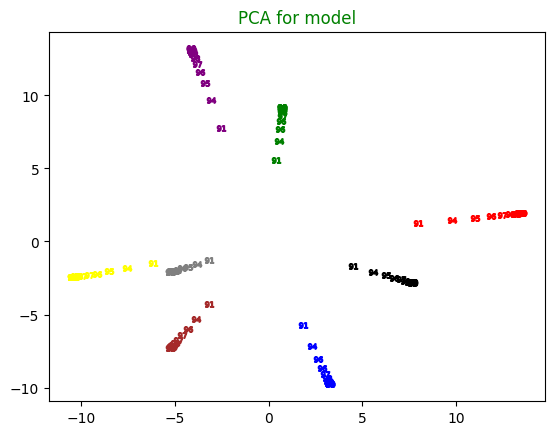

<Figure size 5000x2500 with 0 Axes>

In [73]:

for i in range(len(mv)):
    m = mv[i]
    c = epoch3Df['Iteration'][i]
    plt.scatter(epoch3Df['x'][i],epoch3Df['y'][i],marker=f'${m}$',color = cmap[c])
    plt.title("PCA for model",color="g")
    
plt.figure(figsize=[10,5],dpi=500)

plt.show()

In [74]:
layer1_Df = all_df.iloc[:,0:7840]


In [75]:
t2 = layer1_Df 
t2 = np.array(t2)
pca = PCA(n_components=2)
new_data2 = pca.fit_transform(t2)

In [76]:
layer1Df = pd.DataFrame(new_data2,columns=['x','y'])

eps_each_time = [i for i in range(max_epochs)] * 8
times = np.repeat([i for i in range(8)],max_epochs)

layer1Df['Epoch']=eps_each_time
layer1Df['Iteration']=(times)
layer1Df["Acc"] = train_acc_data
layer1Df["Loss"] = train_loss_data

layer1Df

,x,y,Epoch,Iteration,Acc,Loss
0,-0.313654,-0.694435,0,0,50.873415,1.328536
1,-0.412428,-0.817864,1,0,88.582841,0.394028
2,-0.457079,-0.900467,2,0,91.481486,0.293641
3,-0.483335,-0.974503,3,0,92.658110,0.249844
4,-0.504958,-1.039513,4,0,93.688368,0.218776
...,...,...,...,...,...,...
355,-0.535133,-0.464124,40,7,99.666014,0.019553
356,-0.535586,-0.458905,41,7,99.649395,0.019079
357,-0.532408,-0.461530,42,7,99.727859,0.017760
358,-0.531222,-0.454873,43,7,99.732552,0.017138


In [77]:
test = np.array(layer1Df.Acc)
mv = []
for i in range(len(test)):
    mv.append(str(int(test[i])))


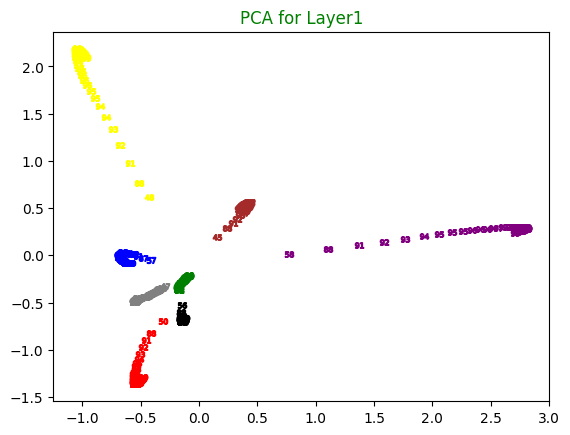

In [78]:
for i in range(len(mv)):
    m = mv[i]
    c = layer1Df['Iteration'][i]
    plt.scatter(layer1Df['x'][i],layer1Df['y'][i],marker=f'${m}$',color = cmap[c])
    plt.title("PCA for Layer1",color="g")


plt.show()